In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import a_mps as mps
import b_model as tfi
import d_dmrg as dmrg
import tfi_exact

In [2]:
L = 14
J = 1
g = 1.5
mps_spinup = mps.init_spinup_MPS(L)
tising = tfi.TFIModel(L, J, g)
dmrg_eng = dmrg.DMRGEngine(mps_spinup, tising, chi_max=30, eps=1.e-12)

In [3]:
E_exact = tfi_exact.finite_gs_energy(L, J, g)
print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))

for i in range(10):
    dmrg_eng.sweep()
    E = tising.energy(mps_spinup)
    print(i+1, ": E =", E, "  \trelative error:", abs((E - E_exact) / E_exact))
print("Final bond dimensions", mps_spinup.get_chi())

Exact diagonalization: E = -23.2229594341173
1 : E = -23.224981768014235   	relative error: 8.708338412578387e-05
2 : E = -23.22295944231679   	relative error: 3.5307699105605556e-10
3 : E = -23.222959434117357   	relative error: 2.6007078344579717e-15
4 : E = -23.222959434117357   	relative error: 2.6007078344579717e-15
5 : E = -23.222959434117353   	relative error: 2.447725020666326e-15
6 : E = -23.22295943411735   	relative error: 2.294742206874681e-15
7 : E = -23.22295943411736   	relative error: 2.753690648249617e-15
8 : E = -23.222959434117357   	relative error: 2.6007078344579717e-15
9 : E = -23.222959434117353   	relative error: 2.447725020666326e-15
10 : E = -23.222959434117353   	relative error: 2.447725020666326e-15
Final bond dimensions [2, 4, 8, 15, 22, 25, 25, 25, 22, 15, 8, 4, 2]


In [15]:
def DMRGsimulation(L, J, g, tol=1.e-5, chi_max=30, eps=1.e-12):
    mps_spinup = mps.init_spinup_MPS(L)
    tising = tfi.TFIModel(L, J, g)
    dmrg_eng = dmrg.DMRGEngine(mps_spinup, tising, chi_max, eps)
    
    # problematic for big L
    # E_exact = tfi_exact.finite_gs_energy(L, J, g)
    # print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))

    i = 0
    E = tising.energy(mps_spinup)
    E_old = 0.
    while(abs(E - E_old) > tol):
        i+=1
        E_old = E
        dmrg_eng.sweep()
        E = tising.energy(mps_spinup)
        # print(i, ":", E)
    print("Iterations:", i)
    print("Final bond dimension:", mps_spinup.get_chi()[L//2])

    return mps_spinup, tising

In [5]:
mps_final, tising_ = DMRGsimulation(L, J, g, chi_max=30, eps=1.e-13)

1 : -23.224981768014235
2 : -23.22295944231678
3 : -23.222959434117353
Iterations: 3
Final bond dimension 27


In [18]:
Ls = [8, 16, 32, 64, 96, 128]
gs = [0.5, 1.0, 1.5]
J = 1
tol = 1.e-5
chi_max = 100
eps = 1.e-12

halfchain_entropy = [[] for _ in range(len(gs))]
for i, g in enumerate(gs):
    for L in Ls:
        mps_final, tising_final = DMRGsimulation(L, J, g, tol, chi_max, eps)
        halfchain_entropy[i].append(mps_final.entanglement_entropy()[L//2])
    print("Half-chain entropy:", halfchain_entropy[i])

Iterations: 3
Final bond dimension: 8
Iterations: 3
Final bond dimension: 26
Iterations: 3
Final bond dimension: 26
Iterations: 3
Final bond dimension: 14
Iterations: 3
Final bond dimension: 14
Iterations: 3
Final bond dimension: 14
Half-chain entropy: [0.6843192425582532, 0.6960190018800835, 0.696067346796638, 0.0029201739311166207, 0.002920173931117469, 0.0029201739311154246]
Iterations: 3
Final bond dimension: 8
Iterations: 3
Final bond dimension: 34
Iterations: 4
Final bond dimension: 65
Iterations: 4
Final bond dimension: 100
Iterations: 4
Final bond dimension: 100
Iterations: 5
Final bond dimension: 100
Half-chain entropy: [0.3497145578964889, 0.4216722350792018, 0.4852998971425024, 0.5457244295331072, 0.5803631847138363, 0.6047549012952119]
Iterations: 3
Final bond dimension: 8
Iterations: 3
Final bond dimension: 26
Iterations: 3
Final bond dimension: 28
Iterations: 3
Final bond dimension: 28
Iterations: 3
Final bond dimension: 28
Iterations: 3
Final bond dimension: 28
Half-chai

 
0.08518 x + 0.1915 
S(L) = c/6 * log(L) -> c = 0.5110828471124241


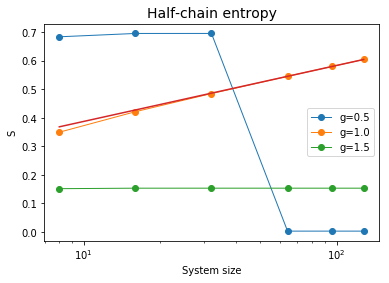

In [36]:
for i in range(len(gs)):
    plt.plot(Ls, halfchain_entropy[i], '-o', linewidth=1., label='g='+str(gs[i]))

# S(L) = c/6 * log(L)
fitcoeff = np.polyfit(np.log(Ls[-3:]), halfchain_entropy[1][-3:], 1) # 1st degree
pol = np.poly1d(fitcoeff)
print(pol, "\nS(L) = c/6 * log(L) -> c =", 6 * fitcoeff[0])
plt.plot((Ls), pol(np.log(Ls)))

plt.xscale("log")
plt.legend()
plt.xlabel('System size', fontsize=10)
plt.ylabel('S', fontsize=10)
plt.title('Half-chain entropy', fontsize=14)
plt.show()

In [41]:
# correlations <ψ| X_i Y_j |ψ> for j ≥ i.
def equaltime_Correlation(psi, X, Y, i):
    L = psi.L
    assert i < L
    corrs = []
    
    # first case: j = i
    # Note: psi.get_theta(i) = Lambda[i] B[i] with axes vL i vR
    theta = psi.get_theta1(i)  # vL i vR
    X_Y_theta = np.tensordot(np.dot(X, Y), # i [i*], [i] i*
                             theta, axes=([1], [1]))  # i [i*], vL [i] vR
    contr = np.tensordot(theta.conj(), X_Y_theta,
                         axes=([0, 1, 2], [1, 0, 2])) # [vL*] [i*] [vR*], [i] [vL] [vR]
    corrs.append(contr)

    return corrs

In [42]:
psi, model = DMRGsimulation(14, 1., 1.5, chi_max=30, eps=1.e-10)
sx = model.sigmax
equaltime_Correlation(psi, sx, sx, model.L//2)

Iterations: 3
Final bond dimension: 18


[array(1.)]